<a href="https://colab.research.google.com/github/jrosko/Bits-of-Analysis/blob/master/k_anonymity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [51]:
import pandas as pd
import numpy as np


<font color='red'>a)
Randomly generate a dataset (dataframe) with eight columns and 50,000 rows. Each
column should be a categorical variable (of arbitrary name) with three levels (of arbitrary names) in approximately equal proportions.</font> 

To begin I will define two functions

1.   One to transform an octuple of random integers into an octuple of random qualitative variables, where integers $\{0,1,2\}$ get mapped to $\rm \{low, med, high\}$
2.   Second, to use the first function to create $n_{rows}$ octuples where each individual element is randomly picked from  $\rm \{low, med, high\}$

Afterwards, I use the second function to create the n=50 000 data set, and print the shape parameter

In [52]:
def int_to_str(array):
    """ Takes an array of random integers, with 3 possible values, 0, 1 or 2.  Then replaces
    0 with 'low', 1 with 'med' and 2 with 'high  """
    result=[]
    for value in array:
        if value==0:
            result.append('low')
        elif value==1:
            result.append('med')
        elif value==2:
            result.append('high')
    return result

def make_sample(nrow):
    """ Creates a sample of 'nrow' rows, where each row is an octuple [X_1, ..., X_8], and 
    each X is randomly chosen from the set {'low', 'med', 'high'}"""
    result = []
    for n in range(0,nrow):
        rnd = np.random.randint(0,3,size=8)
        values = int_to_str(rnd)
        result.append(values)
    return np.array(result)

sample = make_sample(50000)
sample.shape

(50000, 8)

<font color='red'>  b)
Verify that the proportions of each value are similar for each of the eight columns. </font>

In [53]:
def col_proportions(column):
    """ Returns the number of 'low', 'med' and 'high', in list form,
    for an input column vector """
    low, med, high = 0,0,0
    for item in column:
        if item=='low':
            low = low + 1
        elif item=='med':
            med = med + 1
        elif item=='high':
            high = high + 1
    return [low, med, high]

# sample organised into column vectors
col_vectors = sample.T
# Auxiliary list of variable names
varnames = ['Var'+str(n) for n in range(0,8)]
# Compose a dictionary of type Var_name : [ n_low, n_med, n_high] for each of the 8 categorical variables
col_propors = {varnames[n]:col_proportions(column) for (n,column) in enumerate(col_vectors)}
# Use this to construct a dataframe
df = pd.DataFrame(col_propors, index=['LOW', 'MED', 'HIGH'])
# Print the output.
df

,Var0,Var1,Var2,Var3,Var4,Var5,Var6,Var7
LOW,16743,16614,16654,16775,16662,16654,16606,16677
MED,16637,16762,16716,16630,16571,16783,16522,16563
HIGH,16620,16624,16630,16595,16767,16563,16872,16760


<font color='red'> c)How many unique rows (i.e., permutations of category levels) are possible?</font>

It is theoretically possible to draw $\rm 3^8 = 6561$ unique 8-tuples from a 3 variable set ('low', 'med', 'high'). Below we will computationally verify this while constructing a reference set used for counting and grouping identical 8-tuples in the 'experimental' sample

<font color='red'> d) Write some code to produce a table and graph which show the frequencies (numbers
of groups) by permutation group sizes (up to group size of 10). </font>

To solve this, I will produce an array of row-vectors containing of all possible unique 8-tuples (reference set). Then I will pick out the reference tuples one by one, and compare it against each of the 50 000 row-vectors in the data sample. Every time I find >= 10 matches for a given reference tuple, I will terminate the search, to save on computation time.

In [54]:
import itertools
reference = itertools.product(['low','med', 'high'], repeat=8)
reference = tuple(reference)
#Check the size of the reference sample
print('Size of the reference sample',len(reference))

all_sizes=[]
for N in [50000]: # [] as I had a list of different sizes at some point, still used the result for N=30k to make the plot below
    sample = make_sample(N)
    counts = np.zeros(len(reference)).astype(int)
    sizes = np.zeros(11).astype(int) # An array of length 11, which will increment the m-th index, every time a group of m identical tuples is found
    k=0
    for row_r in reference:
        for row_s in sample:
          if row_r==tuple(row_s):
              counts[k] += 1
          if counts[k]==10:
              break
        sizes[counts[k]] = sizes[counts[k]] + 1
        k = k + 1
    all_sizes.append(sizes)


Size of the reference sample 6561


In [57]:
all_sizes

[array([   5,   23,   95,  241,  460,  700,  880,  911,  916,  779, 1551])]

Produce the group size table for the n=50000 sample, and graph the group size distribution. The group size = 10 value is plotted as an outlier of the distribution, as it contains values that would have been resolved into higher group size bins if the counting cut off was >10.

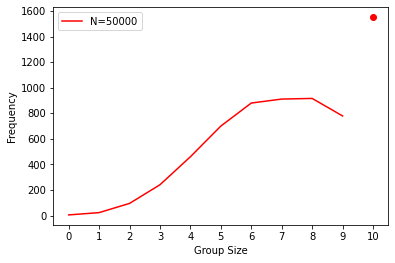

,Group Size,Frequency
,0,5
,1,23
,2,95
,3,241
,4,460
,5,700
,6,880
,7,911
,8,916
,9,779


In [61]:
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

x_ax = np.arange(0,11,1)
plt.plot(x_ax[:-1], all_sizes[0][:-1], '-', color='red', label = 'N=50000')
plt.plot(x_ax[-1], all_sizes[0][-1], 'o', color='red')
##plt.plot(x_ax[:], all_sizes[1][:], '-', color='orange', label = 'N=30000')
plt.legend()
plt.xticks(x_ax)
plt.xlabel('Group Size')
plt.ylabel('Frequency')
plt.show()

# Make a table
groupfreq = {'Group Size' : x_ax, 'Frequency' : all_sizes[0] }
groupfreq_frame = pd.DataFrame(groupfreq,index=['']*11)
# Print the output.
groupfreq_frame

In [ ]:
all_sizes[1]

<font color='red'> e)
Comment upon the distribution of group sizes in d).</font>

The group sizes are distributed around a mean that depends on the size of the initial sample. 
For samples of size N=30 000 and below, the distribution has a long tail and the mass is concentrated at lower group sizes.
However, the mean value drifts to the right with increasing N, and the distribution becomes symmetric when N is around 50 000. In the plot above this is not entirely visible as the group size counting cut off needs to be larger 

<font color='red'> 

f)
If your random variables were, in fact, meaningful information on individuals, which
group sizes are of most concern from a privacy perspective? </font>

Small group sizes would be most problematic. When a set of parameters is less common, the individuals are more identifiable. Especially when there is plenty of additional information available online (social media footprint, phone books, advertising data) that can be cross referenced with whatever is inferred from patient records. 

<font color='red'>g)
Consider the effect of missing data in the dataset you created in Part a). How might
this complicate the production of a frequency table of group sizes in Part d)? </font>

Randomly occuring missing data would essentially add another level to the categorical variables. This would take away members from some of the groups, and depending on the proportion of the 'missing data variable', cause a redistribution of sizes towards smaller groups.

